In [37]:
import numpy as np
from numpy.linalg import inv
import scipy.linalg as sp
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from math import ceil
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import trapz
import h5py
from scipy.optimize import curve_fit
import ana_cont.continuation as cont
import contextlib
import io
import sys

sys.path.insert(0, "./")
from ipynb.fs.full.DMFT_tools import Hamiltonian, get_Bandstructure
from ipynb.fs.full.DMFT_tools import w2dyn, plot_object, S_iw_adjust, cut_matsubara
from ipynb.fs.full.DMFT_tools import real_to_bloch, get_Hk
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [38]:
#### Names for plots
prefix = "NiO_"
postfix = "_0_GPa.png"
#### calculation parameters
do_analytic_continuation = True
num_iter = 1
num_ineq = 1
num_spins = 2
beta = 39.0
#### ana_cont parameters
use_preblur = False
bw = 1e-3         ## Preblur width
aerr_s = 1e-3
alpha_det_method ="chi2kink"
#### cutoff freqs parameters
nKeep = 200       ## Number of Matsubara freqs. kept
nStep = 1         ## every nStep-th element is taken from 0 to nKeep
n_w = 1001        ## Number of real frequencies

In [39]:
DMFT_results = w2dyn(_num_iter = num_iter, beta = beta, _num_ineq = num_ineq)
DMFT_results.get_results("./DMFT_NiO.hdf5")
dos_dft = np.genfromtxt('../DOS/NiO.dos' )

In [40]:
iw_src = DMFT_results.iw
## Better to use a dictionary because num_wann can change between atom 1 and atom N
G_iw_m_s_a_src = {}
G_iw_m_a_src = {}
G_iw_a_src = {}
G_iw_m_a = {}

mu = DMFT_results.mu[-1]

for ineq in range(0, num_ineq):
    G_iw_m_s_a_src[ineq] = DMFT_results.G_iw_m_s[ineq]
    G_iw_m_a_src[ineq] = np.mean(G_iw_m_s_a_src[ineq], axis=1)
    G_iw_a_src[ineq] = DMFT_results.G_iw[ineq]

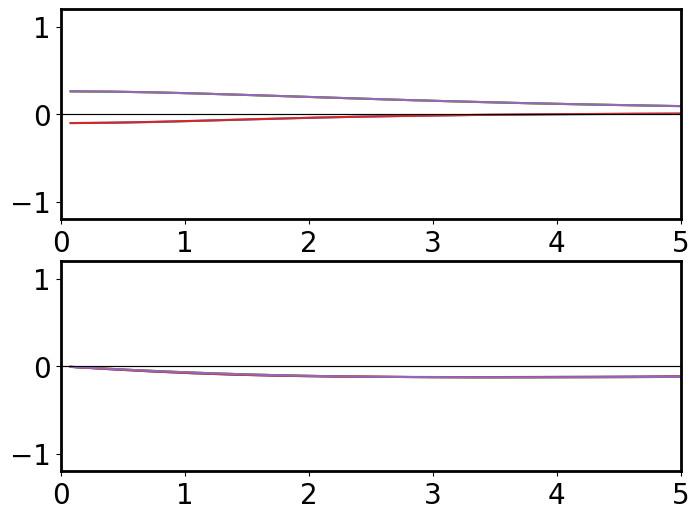

In [41]:
## Analytic continuation of G
w_max = 15
num_wann = {}
iw_err = np.ones((nKeep,), dtype=np.float64) * aerr_s

fig, axs = plt.subplots(2, 1, figsize=(8,6))

idx_roll = 0
for ineq in range(0, num_ineq):
    num_wann[ineq] = G_iw_m_s_a_src[0].shape[0]
    for i in range(0, num_wann[ineq]):
        label=None
        iw, G_iw_m_a[idx_roll] = cut_matsubara(iw_src, G_iw_m_a_src[ineq][i,:], nKeep, nStep)
        axs[0].plot(iw, G_iw_m_a[idx_roll].real, label=label)
        axs[1].plot(iw, G_iw_m_a[idx_roll].imag, label=label)
        idx_roll += 1
        for ax in axs:
            ax.axhline(0, color="black", linewidth=0.75)
            ax.set_xlim(0, 5)
            ax.set_ylim(-1.2,1.2)

In [42]:
w = np.linspace(-w_max, w_max, num=n_w, endpoint=True)
model = np.ones_like(w)
model /= np.trapz(model, w)

In [ ]:
cont_problem = {}
sol = {}

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, num_wann[ineq]):
        cont_problem[idx_roll] = cont.AnalyticContinuationProblem(im_axis = iw, 
    re_axis = w, im_data = G_iw_m_a[idx_roll], kernel_mode = 'freq_fermionic', beta=beta)
        if do_analytic_continuation:
            sol[idx_roll], _ = cont_problem[idx_roll].solve(method = 'maxent_svd', 
    optimizer = 'newton', alpha_determination = alpha_det_method, model=model, stdev=iw_err,
    alpha_start=1e12, alpha_end=1e-4, interactive=True, preblur=use_preblur)
        idx_roll += 1

1001 data points on real axis
400 data points on imaginary axis
50 significant singular values
Precomputation of coefficient matrices...


In [ ]:
G_w_m = {}
G_w_tot = np.zeros(w.shape) + 0.j

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, num_wann[ineq]):
        G_w_m[idx_roll] = cont.GreensFunction(spectrum=sol[idx_roll].A_opt, 
    wgrid=w, kind="fermionic",).kkt()
        G_w_tot += G_w_m[idx_roll]
        idx_roll += 1

In [ ]:
labels = [[r"$d_{z^2}$", r"$d_{xz}$", r"$d_{yz}$", r"$d_{x^2-y^2}$", r"$d_{xy}$"]]
fig, axs = plt.subplots(1, 1, figsize=(9,6))
axs.axhline(0, color="black", linewidth=0.75)
#axs.plot(w, -G_w_tot.imag/np.pi, linewidth=2,linestyle="solid", color="black", zorder=10)

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, num_wann[ineq]):
        label=r"$-1/\pi Im(G_{" + str(i+1) +  "}(i\omega)$)"
        axs.plot(w, -G_w_m[idx_roll].imag/np.pi, linewidth=2,
            linestyle="solid", label=labels[ineq][i])
        idx_roll += 1

#Ef_dft = 6.433238
#axs.plot(dos_dft[:,0]-Ef_dft, gaussian_filter1d(dos_dft[:,1],2)/2, linewidth=2, label="DFT", linestyle="dashed", color="tab:red")

axs.legend(loc="upper right", ncol=1, fontsize=18)
axs.set_ylabel(r"$A(\omega)$")
axs.set_title(r"$Ni$")
axs.set_xlim(-12,8)
#axs.set_ylim(0,1)
#axs.legend()


plotname = prefix + "spectral_fun" + postfix
plt.savefig(plotname, dpi=300, facecolor="white")
plt.show()

In [ ]:
n_elect = 0

idx_roll = 0
for ineq in range(0, num_ineq):
    for i in range(0, num_wann[ineq]):
        mask_occupied = w < 0
        n_elect += np.trapz(-G_w_m[idx_roll][mask_occupied].imag/np.pi, w[mask_occupied])
        idx_roll += 1
        
### This does not count electrons correctly, should be fixed.
### print("There are ", n_elect, " e/atom in your system.\nIs this what you expect?")